# BE 2 Systèmes simples de reconnaissance de la parole
-----------------------------------------------------------------------
### Tariq CHELLALI et Ayoub Toudghi
### 30/12/2023

----------------------------------------------------------------------------------------------------------------

## 01 - READ audio file

On commance par installer les librairies nécessaires pour ce BE.

In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


On utilise le code fourni pour lire la video: 

In [2]:
import librosa
audio, Fe = librosa.load('digit_dataset/0/0_jackson_0.wav') 
print(audio, Fe)

[-0.01060764 -0.01393969 -0.01355745 ...  0.00738658  0.00377755
  0.        ] 22050


Dans ce cas:
- ""audio"" est un vecteur numpy contenant les valeurs des échantillons audio 
- ""Fe"" est la fréquence d’échantillonnage. 

Visualisons cette audio: 

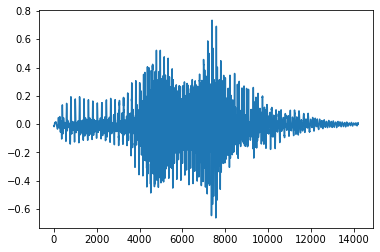

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# visualiser audio est un vecteur numpy contenant les valeurs des échantillons audio et Fe est la fréquence d’échantillonnage.
plt.plot(audio)

Voici un autre exemple de code permettant de parcourir une arborescence afin d’accéder aux 
fichiers audio (.wav) :

In [4]:
import os
list_of_s = []
input_folder='./digit_dataset' 
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder): 
        continue
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        list_of_s.append(filepath)

## Partie 1 : Développement d’un système de reconnaissance de la parole basé sur les coefficients LPC et la classification des k plus proches voisins utilisant la distance élastique

### 1.1 Paramétrisation des données audio à partir des coefficients LPC

- Calculer leur matrice des coefficients LPC

La méthode de Yule-Walker pour le calcul des coefficients LPC suit ces étapes :

Autocorrélation : Calculez l'autocorrélation du signal audio, qui est la corrélation du signal avec lui-même à différents décalages.

Formez une matrice R (matrice de Toepliz) symétrique à partir des valeurs d'autocorrélation. La symétrie vient de la nature stationnaire du signal sur la trame, impliquant que R(i)=R(−i).

Résolution de l'équation : Utilisez l'équation de Yule-Walker, qui relie les autocorrélations aux coefficients LPC. La résolution se fait typiquement par l'équation récursive:

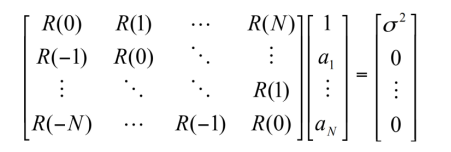

Coefficients LPC : Les solutions de l'équation de Yule-Walker sont les coefficients LPC. Ils vont etre utilisés pour prédire les échantillons de signal audio basés sur une combinaison linéaire des échantillons précédents.

Pour simplifier, sigma  la puissance de l'erreur de prédiction est égale à 1 dans notre cas.

In [5]:
import numpy as np
from scipy.linalg import solve_toeplitz

def calculate_lpc_coefficients(signal, order):
    """
    Calcule les coefficients LPC en utilisant l'équation Yule-Walker method.
    
    :param audio: The audio signal as a numpy array.
    :param order: The order of the LPC.
    :return: The LPC coefficients.
    """
    # Normalisation du signal
    signal = signal / np.max(np.abs(signal))
    # Calcul de l'autocorrélation du signal
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+order+1]
    # Création de la matrice de Toeplitz pour les autocorrélations
    R = autocorr[:order]
    # Résolution de l'équation de Yule-Walker pour sigma^2 = 1
    lpc_coeffs = solve_toeplitz((R, R), autocorr[1:order+1])
    return lpc_coeffs

# Chargement de l'audio et calcul des coefficients LPC
audio, Fe = librosa.load('digit_dataset/0/0_jackson_0.wav')
order = 12  # Ordre du modèle LPC
lpc_coeffs = calculate_lpc_coefficients(audio, order)
print("LPC Coefficients:", lpc_coeffs)

LPC Coefficients: [ 4.27245879 -7.6042      6.23463362 -0.03032483 -5.01047529  4.35811439
  0.50514674 -5.51232091  7.7263345  -6.31947964  3.04462063 -0.67003128]


La fonction ci-dessus permet de calculer les coefficient LPC en se basant sur l'équation de Yule-Walker: 

-- Normalisation : Elle normalise le signal pour que son amplitude maximale soit de 1. Cela permet de rendre les calculs des coefficients indépendants de l'amplitude du signal d'entrée.

-- Autocorrélation : Elle calcule l'autocorrélation du signal audio normalisé pour obtenir une séquence de valeurs représentant la corrélation du signal avec lui-même à différents décalages.

-- Matrice de Toeplitz R : Elle forme une matrice de Toeplitz à partir des valeurs d'autocorrélation. Cette matrice est symétrique et encode les relations linéaires entre les échantillons du signal.

-- Résolution de Yule-Walker : Avec sigma^2 = 1, elle résout l'équation de Yule-Walker pour obtenir les coefficients LPC, en utilisant la fonction solve_toeplitz qui est optimisée pour les matrices de Toeplitz.

### 1.2  Calculer et afficher la matrice des distances entre les signaux audio

### 1-2-1 Spliting dataset to training-test 

In [6]:
import os
import random
    
audio_files = []
labels = []
audio_directory = "digit_dataset/"
# Parcourir les dossiers de chiffres et collecter les noms de fichiers
for i in range(10):
        digit_folder = audio_directory + str(i)
        print(digit_folder)
        if os.path.exists(digit_folder):
            for filename in os.listdir(digit_folder):
                if filename.endswith('.wav'):
                    audio, _ = librosa.load(os.path.join(digit_folder, filename)) 
                    audio_files.append(audio)
                    labels.append(i)
print("Reading and storing audio and labels complete !")
# Mélanger les données tout en conservant la correspondance entre audio_files et labels
combined = list(zip(audio_files, labels))
random.shuffle(combined)
audio_files[:], labels[:] = zip(*combined)
# Séparer les données de test
test_size=0.2 # 20% pour test
split_index = int(len(audio_files) * (1 - test_size))
training_files = audio_files[:split_index]
training_labels = labels[:split_index]
test_files = audio_files[split_index:]
test_indices = list(range(split_index, len(audio_files)))

digit_dataset/0
digit_dataset/1
digit_dataset/2
digit_dataset/3
digit_dataset/4
digit_dataset/5
digit_dataset/6
digit_dataset/7
digit_dataset/8
digit_dataset/9
Reading and storing audio and labels complete !


In [117]:
print("Nombre de fichiers d'entraînement :", len(training_files))
print("Nombre d'Étiquettes d'entraînement :", len(training_labels))
print("Nombre de fichiers de test :", len(test_files))
print("Nombre d'indices de test :", len(test_indices))
print("Taille de chaque audio dans notre jeu de donnée : ", len(training_files[0]))

Nombre de fichiers d'entraînement : 1595
Nombre d'Étiquettes d'entraînement : 1595
Nombre de fichiers de test : 399
Nombre d'indices de test : 399
Taille de chaque audio dans notre jeu de donnée :  10874


### 1-2-2 Prametrisation par coeeficient LPC 

Aprés, nous allons paramétriser nos audio, en utilisant la fonction défini en dessus (paramétrisation par coeeficient LPC)

In [184]:
# Convertir les fichiers audio en séquences LPC
training_lpc = [calculate_lpc_coefficients(file, 4) for file in training_files]
test_lpc = [calculate_lpc_coefficients(file, 4) for file in test_files]

In [185]:
print("Nombre de fichiers d'entraînement :", len(training_lpc))
print("taille du vecteur LPC :", len(training_lpc[0])) 

Nombre de fichiers d'entraînement : 1595
taille du vecteur LPC : 4


### Calcul de la matrice de distance en utilisant la matrice de distance élastique

La distance élastique est calculée en utilisant l'equation vue 
relation de récurrence qui permet de trouver le chemin optimal alignant deux séquences de données temporelles. La fonction g(i, j) représente le coût cumulé pour aligner les points jusqu'aux positions i et j dans les deux séquences. Les pondérations ω v, ω d et ω h permettent d'ajuster le coût en fonction de l'orientation du chemin (verticale, diagonale, horizontale). La distance DTW totale entre deux séquences est le coût g à la fin des deux séquences, c'est-à-dire g(I, J). Le chemin optimal peut être retracé à partir de ce point jusqu'au début des séquences (1,1).

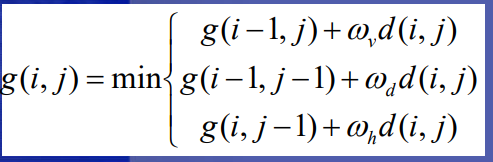

Nous allons implémenter dabord la fonction de distance élastique que nous utiliserons dans la fonction de KNN.

In [186]:
import numpy as np

def distance_elastique(sequence1, sequence2, omega_v=1, omega_d=1, omega_h=1):
    len_s1, len_s2 = len(sequence1), len(sequence2)
    dtw_matrix = np.full((len_s1 + 1, len_s2 + 1), np.inf)
    # Coût initial
    dtw_matrix[0, 0] = 0
    # Remplissage de la matrice
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = abs(sequence1[i - 1] - sequence2[j - 1])
            vertical = dtw_matrix[i - 1, j] + omega_v * cost
            diagonal = dtw_matrix[i - 1, j - 1] + omega_d * cost
            horizontal = dtw_matrix[i, j - 1] + omega_h * cost
            dtw_matrix[i, j] = min(vertical, diagonal, horizontal)
    
    return dtw_matrix[len_s1, len_s2]
# Exemple d'utilisation
seq1 = list_lpc[0]
seq2 = list_lpc[1]
dist = distance = distance_elastique(seq1, seq2)
print(dist)

0.08636150285222788


Nous allons utiliser cette fonction pour calculer la matrice de distance qui sera utiliser dans l'implémentation de la fonction KNN.

In [187]:
def calculate_dtw_distance_matrix(lpc_sequences):
    num_sequences = len(lpc_sequences)
    distance_matrix = np.zeros((num_sequences, num_sequences))

    # Calculer la distance DTW entre chaque paire de séquences LPC
    for i in range(num_sequences):
        for j in range(i+1, num_sequences):  # Pas besoin de calculer la diagonale
            distance = distance_elastique(lpc_sequences[i], lpc_sequences[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # La matrice est symétrique

    return distance_matrix

# Supposons que `lpc_sequences` est une liste de séquences LPC pour chaque signal audio
# Exemple d'utilisation:
distance_matrix = calculate_dtw_distance_matrix(training_lpc + test_lpc)
print("Matrice des distances DTW :")
print(distance_matrix)


Matrice des distances DTW :
[[0.         0.39065453 1.15136904 ... 0.31364866 0.50042958 1.08790139]
 [0.39065453 0.         1.48439552 ... 0.69446671 0.88124763 1.46871944]
 [1.15136904 1.48439552 0.         ... 0.83913178 0.70648493 0.14748994]
 ...
 [0.31364866 0.69446671 0.83913178 ... 0.         0.18678092 0.77425273]
 [0.50042958 0.88124763 0.70648493 ... 0.18678092 0.         0.58747181]
 [1.08790139 1.46871944 0.14748994 ... 0.77425273 0.58747181 0.        ]]


In [188]:
print(len(distance_matrix))
print(len(training_lpc))
print(len(test_lpc))

1994
1595
399


In [189]:
def k_nn_elastique(distance_matrix, training_labels, test_indices, k):
    """
    Classifie les données de test à l'aide de l'algorithme k-NN sur la matrice de distance.

    :param distance_matrix: La matrice complète des distances entre toutes les données.
    :param training_labels: Les étiquettes pour chaque donnée d'entraînement.
    :param test_indices: Les indices des données de test dans la matrice de distance.
    :param k: Le nombre de voisins à considérer pour la classification.
    :return: Les étiquettes prédites pour les données de test.
    """
    predicted_labels = []

    for test_idx in test_indices:
        # Calculer les distances entre le point de test et tous les points d'entraînement
        distances = distance_matrix[test_idx, :len(training_labels)]
        # Obtenir les indices des k plus proches voisins
        neighbors_indices = np.argsort(distances)[:k]

        # Obtenir les étiquettes des plus proches voisins
        neighbors_labels = []

        for idx in neighbors_indices:
            neighbors_labels.append(training_labels[idx])

        # Trouver l'étiquette majoritaire parmi les voisins
        label = max(set(neighbors_labels), key=neighbors_labels.count)
        predicted_labels.append(label)

    return predicted_labels

In [214]:
# Réaliser la classification
predictions = k_nn_elastique(distance_matrix, training_labels, test_indices, k=60)
print("Prédictions k-NN :", predictions)

Prédictions k-NN : [8, 3, 3, 1, 3, 7, 7, 5, 2, 9, 5, 4, 4, 5, 7, 1, 7, 4, 2, 7, 3, 5, 5, 3, 8, 5, 5, 8, 7, 0, 6, 8, 3, 2, 1, 3, 3, 9, 7, 8, 3, 3, 8, 7, 0, 3, 6, 2, 3, 9, 2, 3, 3, 3, 1, 8, 3, 7, 6, 5, 8, 9, 5, 7, 0, 6, 4, 2, 9, 6, 3, 5, 3, 6, 7, 9, 3, 2, 3, 9, 2, 3, 7, 8, 6, 2, 2, 4, 9, 2, 3, 5, 4, 3, 3, 2, 2, 2, 4, 7, 5, 7, 9, 3, 9, 7, 9, 1, 8, 6, 7, 0, 3, 7, 1, 7, 8, 3, 3, 7, 3, 1, 8, 9, 2, 3, 8, 7, 9, 5, 5, 7, 8, 5, 8, 5, 5, 0, 4, 0, 0, 8, 7, 5, 4, 9, 8, 6, 5, 7, 9, 5, 2, 7, 7, 2, 9, 2, 7, 0, 9, 7, 7, 8, 7, 8, 2, 0, 7, 2, 2, 3, 8, 0, 5, 4, 8, 2, 7, 5, 8, 0, 2, 3, 2, 9, 1, 4, 2, 5, 7, 2, 8, 5, 9, 8, 4, 8, 0, 8, 9, 6, 2, 1, 7, 8, 3, 8, 0, 3, 3, 2, 2, 2, 2, 8, 9, 8, 3, 0, 3, 4, 9, 2, 2, 3, 2, 8, 4, 5, 8, 2, 5, 2, 7, 2, 1, 4, 2, 2, 5, 7, 5, 3, 5, 5, 8, 7, 6, 2, 4, 5, 0, 2, 7, 4, 1, 1, 9, 6, 5, 8, 7, 5, 8, 4, 9, 3, 0, 7, 0, 2, 6, 3, 3, 6, 1, 2, 7, 2, 8, 5, 4, 0, 1, 8, 8, 5, 2, 0, 4, 2, 8, 3, 2, 9, 2, 6, 0, 1, 0, 7, 5, 5, 8, 2, 3, 3, 0, 8, 4, 3, 3, 2, 2, 7, 2, 2, 3, 2, 5, 3, 5, 7, 7, 7, 9,

### Evaluation du modèle

In [215]:
test_labels = [labels[i] for i in test_indices] 
accuracy = sum(pred == true for pred, true in zip(predictions, test_labels)) / len(test_labels)
print("Exactitude :", accuracy)

Exactitude : 0.3032581453634085


In [216]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score

# Création de la matrice de confusion
conf_mat = confusion_matrix(test_labels, predictions)

# Calcul du rappel
recall = recall_score(test_labels, predictions, average='macro')

# Calcul du score F1
f1 = f1_score(test_labels, predictions, average='macro')

print("Rappel :", recall)
print("Score F1 :", f1)


Rappel : 0.3123368515920781
Score F1 : 0.3023965913817544


- Exactitude (0.31) : Seulement environ 30% des prédictions sont correctes. Cela indique une faible performance globale du modèle.
- Rappel (0.31) : Le modèle détecte correctement environ 31% des instances positives de chaque classe. Un faible rappel indique que de nombreux cas positifs réels ne sont pas correctement identifiés par le modèle.
- Score F1 (0.30) : Ce score, qui équilibre la précision et le rappel, est également bas. Un score F1 faible suggère que le modèle n'est ni précis ni complet dans ses prédictions.

Pour améliorer le modèle on peut: 

- Augmentation de l'Ordre des LPC : Un ordre plus élevé pour les coefficients LPC peut capturer plus de détails dans les signaux vocaux.

- Normalisation des Données : On normalisant les données, on peut réduire les variations d'amplitude.

- Optimisation des Paramètres : Expérimentez avec différents nombres de voisins (k) dans l'algorithme k-NN.

Données Supplémentaires : Ajouter plus de données d'entraînement pour améliorer la capacité du modèle à généraliser.


In [219]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Stocker les résultats
k_values = range(1, 201)
accuracies = []
f1_scores = []
recalls = []

for k in k_values:
    # Réaliser la classification
    predictions = k_nn_elastique(distance_matrix, training_labels, test_indices, k)
    
    # Calculer les métriques
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    
    # Stocker les résultats
    accuracies.append(acc)
    f1_scores.append(f1)
    recalls.append(recall)

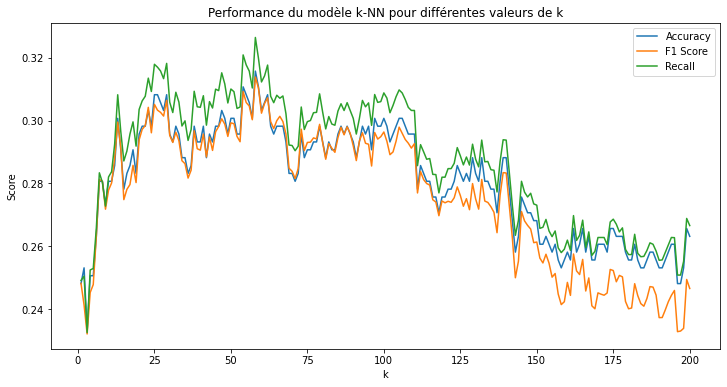

In [220]:
import matplotlib.pyplot as plt
# Création du graphe
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, label='Accuracy')
plt.plot(k_values, f1_scores, label='F1 Score')
plt.plot(k_values, recalls, label='Recall')

# Ajout des légendes et labels
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Performance du modèle k-NN pour différentes valeurs de k')
plt.legend()

# Afficher le graphe
plt.show()

## Partie 2 : Développement d’un système de reconnaissance de la parole basé sur les coefficients MFCC et les Modèles de Markov Cachés. 


----------------------------------------------------------------------

La Partie 2 de ce BE consiste à développer un système de reconnaissance de la parole utilisant les coefficients MFCC (Mel-Frequency Cepstral Coefficients) et les Modèles de Markov Cachés (HMM). Voici une description détaillée de chaque étape, y compris le code pour diviser le jeu de données en ensembles d'entraînement et de test :

In [36]:
import librosa
from librosa.feature import mfcc
audio, Fe = librosa.load('digit_dataset/1/1_theo_47.wav') 
mfcc_features = mfcc(y=audio, sr=Fe, n_mfcc=15, win_length=512, 
hop_length=512//2 )

In [227]:
pip install hmmlearn

### Etape 0: Division du jeux de donnée en un ensemble de test-train 

In [37]:
from sklearn.model_selection import train_test_split

def split_dataset_by_class(dataset, test_size=0.2):
    train_data = []
    test_data = []

    for label, files in dataset.items():
        # Split stratifié pour chaque classe
        train_files, test_files = train_test_split(files, test_size=test_size)
        
        # Ajouter les fichiers et les étiquettes aux ensembles d'entraînement et de test
        train_data.extend([(file, label) for file in train_files])
        test_data.extend([(file, label) for file in test_files])

    return train_data, test_data

### Étape 1 : Extraction des Coefficients MFCC

In [4]:
import librosa
from librosa.feature import mfcc
from hmmlearn import hmm
import numpy as np

# Étape 1 : Extraction des coefficients MFCC
def extract_mfcc(audio_file, n_mfcc=15):
    audio, Fe = librosa.load(audio_file)
    mfcc_features = mfcc(y=audio, sr=Fe, n_mfcc=15, win_length=512, hop_length=512//2)
    return mfcc_features.T 


### Étape 2 : Préparation des Données pour les HMM

In [5]:
# Étape 2 : Préparation des données pour les HMM
def prepare_data_for_hmm(audio_files,  n_mfcc=15):
    X = np.empty((0, n_mfcc))  
    lengths = []
    for file in audio_files:
        mfcc_features = extract_mfcc(file, n_mfcc)
        X = np.append(X, mfcc_features, axis=0)
        lengths.append(len(mfcc_features))
    return X, lengths


### Etape 3: Entraînement des modèles HMM

In [6]:
# Étape 3 : Entraînement des modèles HMM
def train_hmm_models(audio_files_by_class):
    models = {}
    for class_label, files in audio_files_by_class.items():
        X, lengths = prepare_data_for_hmm(files)
        model = hmm.GaussianHMM(n_components=4, n_iter=1000)
        model.fit(X, lengths)
        models[class_label] = model
    return models

### Étape 4 : Reconnaissance et Classification

In [8]:
# Étape 4 : Reconnaissance et Classification
def classify_audio(models, test_audio_file):
    mfcc_features = extract_mfcc(test_audio_file)
    best_score, best_label = float('-inf'), None
    for label, model in models.items():
        score = model.score(mfcc_features)
        if score > best_score:
            best_score = score
            best_label = label
    return best_label

### Étape 5 : Création d'un disctionnaire contenant tout les fichiers audios avec leurs label

In [51]:
import os

def create_audio_files_by_class(audio_directory):
    audio_files_by_class = {}
    # Parcourir chaque sous-dossier (chiffre)
    for chiffre in range(10):
        class_path = os.path.join(audio_directory, str(chiffre))
        if os.path.isdir(class_path):
            audio_files_by_class[chiffre] = []
            for filename in os.listdir(class_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(class_path, filename)
                    audio_files_by_class[chiffre].append(file_path)
    return audio_files_by_class

# Utilisation 
audio_directory = 'digit_dataset'
audio_files_by_class = create_audio_files_by_class(audio_directory)

In [45]:
# Entraîner les modèles HMM
models = train_hmm_models(audio_files_by_class)

c:\Users\tariq\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1321
  warnings.warn(
c:\Users\tariq\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1767
  warnings.warn(


In [50]:
test_label = classify_audio(models, "digit_dataset\9\9_jackson_0.wav")
print(test_label)

9
